##  Opinion Search Engine – Embedding-Based Classification (Method 1)

This notebook implements **Method 1** of our opinion retrieval system by combining sentence embeddings with supervised classification to retrieve reviews that are not only relevant but **sentiment-consistent** with a given query.

###  Overview of Our Approach

- We first retrieve reviews using **Boolean filtering** based on aspect terms.
- Each review is encoded using dense **semantic embeddings** from a pre-trained transformer model.
- A supervised **sentiment classifier** (SVC) is trained using the star ratings as proxy sentiment labels.
- At inference, we **filter reviews whose predicted sentiment aligns with the opinion word** in the query.

This aligns directly with **Method 4.3 (Modeling Linguistic Relevance Using Classification)** from the project instructions.

---

###  Models Used

| Component | Model Used | Description |
|----------|------------|-------------|
| Sentence Embedding | `all-MiniLM-L6-v2` (SentenceTransformers) | Encodes review text into dense vectors capturing semantic meaning. |
| Sentiment Classifier | `SVC(kernel='linear', class_weight='balanced')` or `LogisticRegression()` | Predicts polarity (positive/negative) from embeddings using star ratings as labels. |

---

###  Test Definitions for Evaluation

We evaluate the system using four retrieval criteria outlined in the project:

- **Test 1 – Boolean Aspect Term Retrieval (30%)**  
  The review must contain at least one **aspect** word (e.g., `audio`, `quality`).  
  *No opinion term required.*

- **Test 2 – Aspect AND Opinion Match (20%)**  
  The review must mention both **aspect** and **opinion** terms anywhere in the text.  
  *Proximity or sentiment not enforced.*

- **Test 3 – Aspect OR Opinion Match (20%)**  
  The review must mention **either** the aspect or the opinion term.  
  *Designed to test broader recall.*

- **Test 4 – Proper Connotation Match (30%)**  
  The review must express the **correct sentiment polarity** of the opinion word **toward** the aspect.  
  *Preferably in the same sentence.*

This embedding-based classification approach is designed specifically to support **Test 4**, enforcing correct polarity matching between query intent and retrieved text.

----


### 🌸 Step 1: Install Required Dependencies

We begin by installing the `ipywidgets` package, which is essential for enabling interactive components within Jupyter notebooks. This includes dynamic progress bars and other widget-based tools that will be used throughout the project.

In [1]:
!pip install ipywidgets

### 🌸 Step 2: Load the Cleaned Review Dataset

We load the preprocessed review data stored in a serialized `.pkl` format. This dataset contains Amazon product reviews that have already been cleaned and segmented for analysis.

In [2]:
import pandas as pd
df = pd.read_pickle("reviews_segment.pkl")
review_col = 'review_text'
df.head()

,review_id,product_id,customer_id,review_title,review_written_date,customer_name,review_from_title,review_text,helpful_count,out_of_helpful_count,customer_review_rating,number_of_comments,amazon_verified_purchase,amazon_vine_program_review,review_with_metadata
0,'R10019MUX6F9A','B00006881R','AWNC1GQ75W8K8','Works as advertised','2002-12-17','Neil','TeleZapper TZ 900 (Office Product)','I\'ve had this product for about a month and ...,7,7,4,0,0,0,"('R10019MUX6F9A', 'B00006881R', 'AWNC1GQ75W8K8..."
1,'R1002I943QCT20','B00471F0NK','A3SFG0OC59UXL5',"'macintosh version - bad graphics, bad interface'",'2007-06-05','D. Simons','null','I have been using the Macintosh OSX version o...,21,23,2,0,0,0,"('R1002I943QCT20', 'B00471F0NK', 'A3SFG0OC59UX..."
2,'R1003RILN06MX1','B0027U258Q','A2IP26LJGTJXSV','Great Software','2010-12-05','Tex','Paragon Partition Manager 10 Personal Edition...,'The Partition Manager is a great product. It\...,1,1,5,0,1,0,"('R1003RILN06MX1', 'B0027U258Q', 'A2IP26LJGTJX..."
3,'R100523NBIQIEV','B000070MRB','A2DKAPBHZ5DERR','Neutral','2004-06-07','S. Barnes','Game Programming Starter Kit 6.0 (CD-ROM)','If you plan on getting this program go to htt...,-1,-1,3,0,0,0,"('R100523NBIQIEV', 'B000070MRB', 'A2DKAPBHZ5DE..."
4,'R1006KJEGKGV0O','B001B19D7I','AMZ7EO048MCWK',"'Great seat, but don\'t like the buckle'",'2009-07-07','Cyrca','Britax Boulevard 65 TSIP Convertible Car Seat...,'I researched for months (on-line and in store...,1,1,5,0,0,0,"('R1006KJEGKGV0O', 'B001B19D7I', 'AMZ7EO048MCW..."


### 🌸 Step 3: Initialize Sentence Embedding Model

We load the `all-MiniLM-L6-v2` model from the SentenceTransformers library to encode review texts into dense vector representations. This model provides a good balance between performance and efficiency for semantic tasks.

We also check for GPU availability and assign the model to run on CUDA if available, otherwise defaulting to CPU.


In [3]:
import torch
from sentence_transformers import SentenceTransformer

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)


### 🌸 Step 4: Generate Sentence Embeddings for Reviews

We generate dense vector embeddings for a subset of reviews using the pretrained `all-MiniLM-L6-v2` model. These embeddings capture the semantic meaning of each review and serve as feature representations for downstream classification.

We limit the process to the first 40,000 reviews to ensure efficiency during development. A GPU will be used if available to accelerate encoding.


In [4]:
import torch
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
encoder = SentenceTransformer('all-MiniLM-L6-v2', device=device)

text_col = 'review_text'

texts = df[text_col].astype(str).tolist()
texts_subset = texts[:40000]

print("🌸 Encoding first 40,000 reviews...")

embedding_list = []
for sentence in tqdm(texts_subset, desc="Encoding Reviews"):
    emb = encoder.encode(sentence, convert_to_tensor=True, normalize_embeddings=True)
    embedding_list.append(emb)

embeddings = torch.stack(embedding_list)

print(" 🌸 Encoding complete.")



🌸 Encoding first 40,000 reviews...


Encoding Reviews: 100%|██████████| 40000/40000 [10:44<00:00, 62.09it/s]

 🌸 Encoding complete.


### 🌸 Step 5: Generate Binary Sentiment Labels from Ratings

To train a supervised classifier, we convert the numeric customer review ratings into binary sentiment labels. Ratings greater than 3 are treated as **positive (label = 1)**, and ratings of 3 or lower are treated as **negative (label = 0)**.

We also ensure the rating column is numeric and filter out any invalid or missing values.

In [5]:
df['customer_review_rating'] = pd.to_numeric(df['customer_review_rating'], errors='coerce')
df = df.dropna(subset=['customer_review_rating'])
df['label'] = (df['customer_review_rating'] > 3).astype(int)

### 🌸 Step 6: Prepare Feature Matrix and Target Labels

We convert the stacked embeddings into a NumPy array to serve as the input feature matrix `X`. Corresponding sentiment labels are extracted from the DataFrame to form the target vector `y`.

To ensure alignment, we only select labels for the number of reviews that were embedded (in this case, the first 40,000).


In [6]:
X = embeddings.cpu().numpy()
y = df.loc[:len(X)-1, 'label'].values

### 🌸 Step 7: Split Data into Training and Testing Sets

We partition the dataset into training and testing sets using a 70/30 split. This ensures that the classifier is trained on a subset of the data and evaluated on unseen examples to measure generalization performance.

A fixed `random_state` is set for reproducibility.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 🌸 Step 8: Train Sentiment Classifier (Logistic Regression)

We train a logistic regression model on the sentence embeddings to classify reviews as either positive or negative. Logistic regression is a simple yet effective linear model for binary classification tasks.


In [8]:
from sklearn.linear_model import LogisticRegression
print("\nTraining Logistic Regression classifier...")
clf = LogisticRegression(max_iter=10)
clf.fit(X_train, y_train)


Training Logistic Regression classifier...


C:\Users\jenni\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=10)

### 🌸 Step 9: Evaluate Classifier and Visualize Results

We train a Support Vector Classifier (SVC) using a linear kernel and balanced class weights to handle any label imbalance. The model is then evaluated on the test set, and its performance is reported using standard classification metrics.

A confusion matrix heatmap is generated to visually illustrate the distribution of predictions across true and predicted labels.


 Evaluación con class_weight='balanced':
              precision    recall  f1-score   support

    Negative       0.60      0.77      0.67      3585
    Positive       0.89      0.78      0.83      8415

    accuracy                           0.78     12000
   macro avg       0.74      0.77      0.75     12000
weighted avg       0.80      0.78      0.78     12000



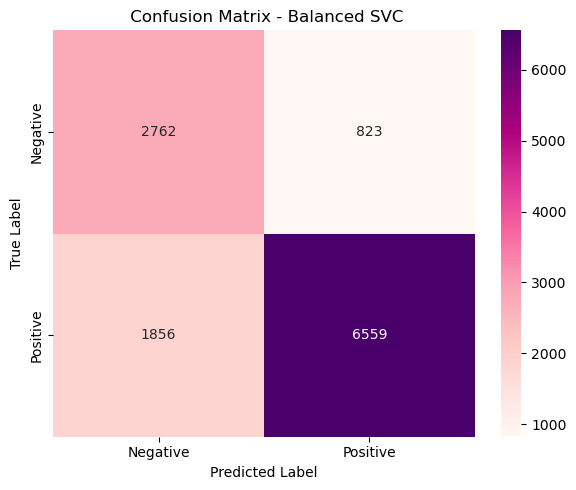

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

clf = SVC(kernel='linear', probability=True, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("\n Evaluación con class_weight='balanced':")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu',  # <-- rosa
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(" Confusion Matrix - Balanced SVC")
plt.tight_layout()
plt.show()



### 🌸 Step 10: Define Aspect–Opinion Queries for Evaluation

We define a set of aspect–opinion query pairs that represent natural language search intents. Each query consists of:
- An **aspect** (e.g., "audio quality", "wifi signal")
- An **opinion term** that reflects sentiment or user judgment (e.g., "poor", "strong", "useful")

These queries will be used to retrieve relevant reviews and assess the system's ability to match both content and sentiment.

In [10]:
queries = {
    "audio quality:poor": ("audio quality", "poor"),
    "wifi signal:strong": ("wifi signal", "strong"),
    "mouse button:click problem": ("mouse button", "click problem"),
    "gps map:useful": ("gps map", "useful"),
    "image quality:sharp": ("image quality", "sharp")
}

### 🌸 Step 11: Retrieve and Filter Reviews by Query Using Classifier Predictions (Test 4: Proper Connotation)

In this step, we evaluate the classifier’s ability to retrieve reviews that not only mention a specific aspect but also express the correct sentiment implied by the opinion term in the query.

For each aspect–opinion query:

- We retrieve all reviews that contain the aspect term.
- We encode these reviews into sentence embeddings using a transformer model.
- We use a trained classifier to predict the sentiment (positive or negative) of each review.
- We define the **expected sentiment polarity** based on the opinion term:
  - If the opinion is "good", "strong", "sharp", or "useful", we expect **positive sentiment** (label = 1).
  - Otherwise, we expect **negative sentiment** (label = 0).
- We retain only reviews whose predicted sentiment matches the expected label.

We save the matching review IDs to `.txt` files in the `Task4.4_ClassifierMatch` folder.

To evaluate the effectiveness of this connotation-based filtering, we compute:
- **Precision** — how many of the predicted sentiment matches were correct
- **Recall** — how many of the correct sentiment reviews were retrieved
- **F1 Score** — the harmonic mean of precision and recall

These scores are reported per query to assess how well the classifier captures the proper opinion orientation.


In [11]:
import os
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

review_col = 'review_text'
os.makedirs("Task4.4_ClassifierMatch", exist_ok=True)

summary = []

for query_label, (aspect, opinion) in queries.items():
    aspect_mask = df[review_col].str.contains(aspect, case=False, na=False)
    subset_df = df[aspect_mask].copy()

    if subset_df.empty:
        print(f"\n🌸 No matches for aspect '{aspect}' in query: {query_label}")
        continue

    subset_emb = []
    for text in tqdm(subset_df[review_col].tolist(), desc=f"Embedding for {query_label}"):
        emb = model.encode(text, convert_to_tensor=True, normalize_embeddings=True)
        subset_emb.append(emb)

    subset_emb = torch.stack(subset_emb).cpu().numpy()
    preds = clf.predict(subset_emb)
    subset_df['predicted_label'] = preds

    expected_label = 1 if opinion.lower() in ['good', 'strong', 'sharp', 'useful'] else 0

    filtered = subset_df[subset_df['predicted_label'] == expected_label]

    print(f"\n🌸 Query: {query_label}")
    print(f"🌸 Matching {len(filtered)} reviews out of {len(subset_df)}")

    if 'review_id' in filtered.columns:
        print("🌸 Matched Review IDs:")
        for rid in filtered['review_id'].dropna().unique():
            print(str(rid).replace("'", "").replace('"', ""))

    if not filtered.empty:
        sample_text = filtered.iloc[0][review_col]
        print(f"🌸 Sample matching review for '{query_label}':\n{sample_text}\n")

    txt_filename = f"Task4.4_ClassifierMatch/{query_label.replace(':', '_').replace(' ', '_')}_method1.txt"
    with open(txt_filename, "w", encoding="utf-8") as f:
        f.write(f"=== Method 1 Output ===\nQuery: {query_label}\n\n")
        for rid in filtered['review_id'].dropna().unique():
            f.write(f"{str(rid).replace("'", "").replace('"', "")}\n")

    print(f"🌸 Saved: {txt_filename}")
    
    y_true = subset_df['label'].tolist()                
    y_pred = subset_df['predicted_label'].tolist()      

    precision = precision_score(y_true, y_pred, pos_label=expected_label, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=expected_label, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=expected_label, zero_division=0)

    summary.append({
        'Query': query_label,
        'Retrieved': len(subset_df),
        'Relevant Retrieved': len(filtered),
        'Precision': round(precision, 2),
        'Recall': round(recall, 2),
        'F1': round(f1, 2)
    })


Embedding for audio quality:poor: 100%|██████████| 352/352 [00:06<00:00, 51.61it/s]



🌸 Query: audio quality:poor
🌸 Matching 129 reviews out of 352
🌸 Matched Review IDs:
R10BB2FGLY2VI4
R11WV7N6F35K3L
R157INYYCFJSQI
R16EZSK95BH7UV
R18QCB08E8JPF6
R18S2OLR5A7M90
R18XFYC2F3VSG1
R19HK51BKLIJ71
R19JH64MT9TTPB
R19XN0WET0G23Z
R1A8DQHYKMDCF6
R1AIS0IYW8FHLP
R1BAT8Z5IZ62L
R1CGDCAFYC75TP
R1CYZPN4URQMCY
R1D1SWNKA0WEV9
R1DBZCB2JSCCDM
R1E3UC5AV5RONW
R1EEV68KN5NVV9
R1EP408TCEABK8
R1FBFQ8DWV60SK
R1GKHS8KF60FHE
R1GMALK930L8Y9
R1H4E7MTCQ2VJR
R1H4GJ607I44CC
R1HGIMKHX23WZE
R1HJPHMU9QBFG1
R1IG7Q8R7PJH2M
R1JDVDV27NEURK
R1JN2A5Y6O7O17
R1JWPMUUX87F2W
R1LN3I0T2371JL
R1M6VX4NSMSB9
R1NEPZESUPTBZ8
R1S2MW08TIY8YR
R1S6NEO0S4HO9C
R1T2LU5TSNPLM5
R1TG7P6PW6G0HH
R1V4TG06TK0RF
R1WC6DCWBLK0UZ
R1XM10NGBDF8IA
R1ZJ6JIC3I43V4
R1ZUNTQLPYZE7Z
R22HA43V2TCU2B
R24J7ZCIHJFFSH
R25QDOOXC9IN0C
R26AWVX4TT9PCT
R26F94XWOLVIRU
R272YQGVGJS0IW
R29C66WD6V5NP7
R2B567RX8V1QFR
R2BP01OZKINOOO
R2C6PW682WZ79T
R2CI7GFYRM7FRH
R2D6MZ0465LEG7
R2DR4EJK5CUHW9
R2FRFAEW08S3WF
R2GSTDXA0PQ5C3
R2H4B4J5QOYXG
R2HZIFVN61AYVZ
R2IVAH7PWYG1B7
R2JR

Embedding for wifi signal:strong: 100%|██████████| 28/28 [00:00<00:00, 48.89it/s]



🌸 Query: wifi signal:strong
🌸 Matching 14 reviews out of 28
🌸 Matched Review IDs:
R12LKKCN038L63
R1GTHDPXLPQVRG
R1T6YH9752WV0F
R26LGAFNU5ZBCA
R27V0A89XREWVI
R2H2EIAT3OSEH3
R2VQ73QW261XGD
R2ZWRR5JHTEGS3
R30LD34EZJOFRU
R3LVTAGC2WMTMN
R9CFYO5N4N0RC
RAV5R3DCUUBEH
RMPL8JFV45X66
RYV1QEVTATVKN
🌸 Sample matching review for 'wifi signal:strong':
'I bought the HD Flow system because I have an HDTV I want to mount in my kitchen, which is at the far end of the second floor of of my three story house.  I received it along with the rest of my install equipment (mount, plugs, wires etc.) from amazon, but the entire install depended on the HD Flow being able to transmit an acceptable signal through my 1st-2nd floor and through a set of two walls to the kitchen TV.  As i write this i realize the feat I am asking for a wireless signal to do, but I was sold by their video that claims 131 feet through floors and walls.  But my transmitter (tX) and receiver (rX) would only be 60 feet apart...that should w

Embedding for mouse button:click problem: 100%|██████████| 111/111 [00:02<00:00, 44.15it/s]



🌸 Query: mouse button:click problem
🌸 Matching 53 reviews out of 111
🌸 Matched Review IDs:
R100G3JLM4FOBV
R11MPUKORD11J9
R12EZ0J6AXL4FU
R1C2VE82XJW5KV
R1MV9K13T9DHI2
R1Q5450ZM8BK4O
R1T9H6KBZX71BU
R1UI7ZX8QV2DPO
R1UUP87DM728QY
R1V00BWZHX1W8G
R1X063C2C3SQI1
R1XITQ8ZY2CE6G
R1ZFI2BXXHRWOX
R220QQRFMCLHK8
R282U2VFMEZ483
R2CGYLDU36TAWH
R2CYD9NQPGTA2D
R2DF8PXPZU6VSB
R2GREB8MLPJ557
R2HNVW3SSQW57Q
R2MEM7MH6I54C
R2MYXSMTQ5TW92
R2QCFRNU8FTFXV
R2T2TJ0MD9AWFH
R2UBK146BMGO90
R2UPY7QZE4J34R
R2UR9CWJGXBZ6M
R2VKV8JJMNXUQS
R2W2VOLBJC7G4C
R2WUSNVEX79SBL
R2YJAC4IWFSYZJ
R2ZG7MOX70FK97
R30RQ1IW429L1C
R32NRHJRXY4ZJ0
R3386BCIAD10A4
R39DDKZYWWNL3R
R39MTLSYHE7KG5
R3AOK6Q6SVCJKL
R3CC0H93WAX7F1
R3FV7M69Z5JVB3
R3JHM8IS58PRSL
R3MVTBH0CL4QV7
R3MY3IUI0D9D97
R3R7OXAI5M62FT
R3SSCFV3HSTSJ9
R3U25JC4U1P75M
R7XKRUIPJHAUG
R9SG3H9OGPOXV
RE2TMWJ54MPJE
RG2XJHEW8JVTO
RRP8IB966LDV7
RTTIPAPLKDTAL
RYXQFFRKNGGNB
🌸 Sample matching review for 'mouse button:click problem':
'The Good:\n- Graphics are good but not spectacular\n- Charact

Embedding for gps map:useful: 100%|██████████| 19/19 [00:00<00:00, 49.56it/s]



🌸 Query: gps map:useful
🌸 Matching 5 reviews out of 19
🌸 Matched Review IDs:
R1DLOH2791LNHU
R1UKYBUX77BPGX
R3JPYHW85OH65J
RDTV2G99WDZND
RFZ3V3FP5TBZ8
🌸 Sample matching review for 'gps map:useful':
'We are completely satisfied with this computer.  Our main use is "on the road" as we have the DeLorme GPS Mapping and the Verizon Nationwide Internet Access installed on it.  We chose the 10-inch over the 8-inch mainly to get the bigger battery.  It really does run for several hours on a charge.  The lack of a CD drive is something to work around.  I connect to my PC through the home network to install application programs.  The computer keeps nagging you to make a factory-image backup by connecting a USB optical drive, and it won\'t allow you to do that over the network or onto a USB flash drive.  Since I don\'t want to invest in an external optical drive, I contacted tech support and they offered to send me a free backup disk of the operating system.  One other thing--invest $12 in a wire

Embedding for image quality:sharp: 100%|██████████| 515/515 [00:11<00:00, 45.74it/s]



🌸 Query: image quality:sharp
🌸 Matching 370 reviews out of 515
🌸 Matched Review IDs:
R10A1EUN5VT1EJ
R10DBATUEKOSRQ
R10DPP06ILH2HN
R1123ESV3ZBKLT
R11W8HW6GC32R5
R1244JE1KLAZUO
R1244MA55GVY4B
R12AUOXT55Q16G
R12UWKQ7LEMKRT
R12XWR6KGTYJ57
R13L07ANDQ7PZX
R14E60K5LEJJ0W
R152O1OAU8B3TO
R152Z2Y2W937QJ
R1567IMWIBQXGY
R15B80KKOYDXGZ
R15CHI635650Z4
R15S9DOO8EIQSL
R15TBWJKCHX4UN
R16F4WYPFF0WK4
R16MPXU5ISP8VE
R16SNFRT7WBDUC
R17CJ36VSSNN9D
R17IS0TM8ETK9Y
R17NBGO37MW92X
R17UE7QUHXGP8P
R184MHMVXMONNV
R188QLTJCKDH8Y
R19K8WYNDS412N
R19MV0AKH9A0DK
R1AD1R59EN2I1L
R1AH219M0NA8Z9
R1BJ9CFCH3LUE1
R1C8IHUWGS51LA
R1C95SNKQ1QKXF
R1CEJLJ43Z9T95
R1CWT8NTRSPBX3
R1DJV87J1EUYYH
R1DPU27DYGDZTG
R1DTCR1ZVS7V03
R1DU1LEY7CDXYF
R1E1ZJAJ0L0LVH
R1ECX2B78L2S6B
R1EJ477OB1ZOAC
R1F39LW2692EKP
R1F91LI6NTFIYU
R1FGGA3RZV0YHW
R1G0SZYAYASS8V
R1GR3RGQTSA6JJ
R1H542TECD3L37
R1H6K6VPKVIA9P
R1HMFYXZNVA7U5
R1IGHHB05PRRPB
R1IJFTFUEGU0X4
R1J5PVOZ950LNB
R1KLYMYUW05GZO
R1KQF4MEGJXB33
R1KTL3W6FPO6HN
R1L8EFCD2DYUAO
R1LO7UDK3DTHU2
R1LPMEJ3XO3QS


### 🌸 Step 12: Visualize Precision per Query

To assess how well the classifier retrieves relevant reviews for each aspect–opinion query, we plot the **precision score** for every query.


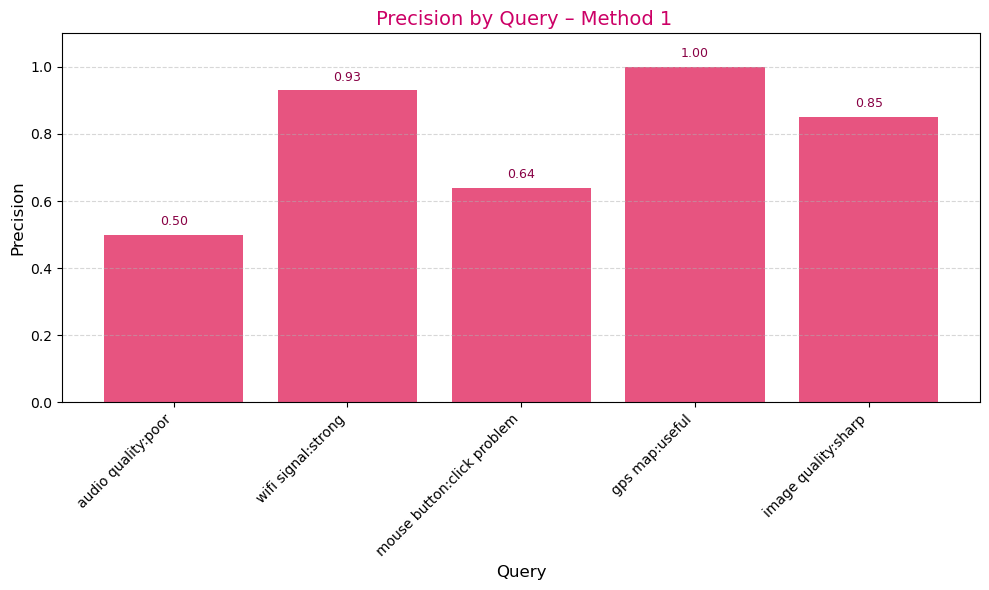

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

summary_df = pd.DataFrame(summary)
plt.figure(figsize=(10, 6))
bars = plt.bar(summary_df['Query'], summary_df['Precision'], color='#e75480')  # Bright pink
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}",
             ha='center', va='bottom', fontsize=9, color='#880044')
plt.ylim(0, 1.1)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title(" Precision by Query – Method 1", fontsize=14, color='#cc0066')
plt.xlabel("Query", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 🌸 Step 13: summary 

In [13]:
summary_df = pd.DataFrame(summary).drop_duplicates()
print("\n🌸 Summary Table:")
print(summary_df.to_string(index=False))


🌸 Summary Table:
                     Query  Retrieved  Relevant Retrieved  Precision  Recall   F1
        audio quality:poor        352                 129       0.50    0.63 0.55
        wifi signal:strong         28                  14       0.93    0.68 0.79
mouse button:click problem        111                  53       0.64    0.77 0.70
            gps map:useful         19                   5       1.00    0.56 0.71
       image quality:sharp        515                 370       0.85    0.82 0.83
